# Data Modelling

## Get the data from the previous notebook

##### Import the libraries

In [1]:
import json
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import xgboost as xgb

##### Get the data from the previous notebook, as csv files, and load them into dataframes

In [3]:
awards_players_df = pd.read_csv('../prep_data/dfs/awards_players_df.csv')
coaches_df = pd.read_csv('../prep_data/dfs/coaches_df.csv')
players_df = pd.read_csv('../prep_data/dfs/players_df.csv')
players_teams_df = pd.read_csv('../prep_data/dfs/players_teams_df.csv')
series_post_df = pd.read_csv('../prep_data/dfs/series_post_df.csv')
teams_post_df = pd.read_csv('../prep_data/dfs/teams_post_df.csv')
teams_df = pd.read_csv('../prep_data/prepared_dataset.csv')

# Make a dictionary with all the dataframes
dfs = {'awards_players_df': awards_players_df, 'coaches_df': coaches_df, 'players_df': players_df, 'players_teams_df': players_teams_df, 'series_post_df': series_post_df, 'teams_df': teams_df, 'teams_post_df': teams_post_df}

### Get the data from competition year

In [4]:
# DB Credentials
with open("../config.json") as config_file:
    config = json.load(config_file)

host = config["db_host"]
user = config["db_user"]
password = config["db_password"]
database = config["db_database"]
schema = config["db_11_schema"]

In [5]:
connection = psycopg2.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor()

def execute(query):
    cursor.execute(query)
    connection.commit()
    return cursor.fetchall()

def fetch(query):
    cursor.execute(query)
    return cursor.fetchall()

SELECT = "SELECT * FROM " + schema + "." # + table_name 
INSERT = "INSERT INTO " + schema + "." # + table_name + " VALUES " + values
UPDATE = "UPDATE " + schema + "." # + table_name + " SET " + column_name + " = " + value
DELETE = "DELETE FROM " + schema + "."  # + table_name + " WHERE " + column_name + " = " + value

In [6]:
coaches = fetch(SELECT + "coaches") # all coaches who've managed the teams during the time period,
players_teams = fetch(SELECT + "players_teams") # performance of each player for each team they played,
teams = fetch(SELECT + "teams") # performance of the teams for each season,

players_teams_11_df = pd.DataFrame(players_teams, columns=['playerID', 'year', 'stint', 'tmID', 'lgID'])
teams_11_df = pd.DataFrame(teams, columns=['year', 'lgID', 'tmID', 'franchID', 'confID', 'name', 'arena', 'playoff'])
coaches_11_df = pd.DataFrame(coaches, columns=['coachID', 'year', 'tmID', 'lgID', 'stint'])

##### Make some preprocessing to year 11 data to make it compatible with the other years

In [7]:
# Iterate over each row in the DataFrame
def franchise_mapping(teams_df, dfs):
    team_franchise_mapping = {}
    for index, row in teams_df.iterrows():
        # Extract team and franchise IDs from the current row
        team_id = row['tmID']
        franchise_id = row['franchID']

        # Check if the team ID is not already in the mapping dictionary
        if team_id not in team_franchise_mapping:
            # Add the team ID and its corresponding franchise ID to the mapping
            team_franchise_mapping[team_id] = franchise_id

    # Now, team_franchise_mapping contains the mapping between team IDs and franchise IDs
    print(team_franchise_mapping)

    for df_name, df in dfs.items():
        # Check if 'tmID' is a column in the current DataFrame
        if 'tmID' in df.columns:
            # Replace team IDs with franchise IDs using the mapping
            df['tmID'] = df['tmID'].map(team_franchise_mapping)
        if 'franchID' in df.columns:
            # Drop the 'franchID' column
            df.drop(columns=['franchID'], inplace=True)

In [8]:
binary_columns = ['confID', 'playoff']

for col in binary_columns:
    teams_11_df[col] = teams_11_df[col].replace('EA', 0)
    teams_11_df[col] = teams_11_df[col].replace('WE', 1)
    teams_11_df[col] = teams_11_df[col].replace('N', 0)
    teams_11_df[col] = teams_11_df[col].replace('Y',1)

franchise_mapping(teams_11_df, {'teams': teams_11_df, 'players_teams': players_teams_11_df, 'coaches':coaches_11_df})


players_teams_11_df = players_teams_11_df.reindex(columns=players_teams_df.columns)
players_teams_df = pd.concat([players_teams_11_df, players_teams_df])
dfs['players_teams_df'] = players_teams_df

teams_11_df = teams_11_df.reindex(columns=teams_df.columns)
teams_df = pd.concat([teams_11_df, teams_df])
dfs['teams_df'] = teams_df

coaches_11_df = coaches_11_df.reindex(columns=coaches_df.columns)
coaches_df = pd.concat([coaches_11_df, coaches_df])
dfs['coaches_df'] = coaches_df

{'SEA': 'SEA', 'WAS': 'WAS', 'LAS': 'LAS', 'MIN': 'MIN', 'PHO': 'PHO', 'SAS': 'SAS', 'TUL': 'DET', 'ATL': 'ATL', 'CHI': 'CHI', 'CON': 'CON', 'IND': 'IND', 'NYL': 'NYL'}


### Normalization and Standardization

We will normalize and standardize the data, so models likes neural networks, linear regression and logistic regression, that assume that the data is normally distributed, can be used.

In [9]:
# for the numeric columns in players_teams_df verify if they follow gaussian distribution
def gaussian_distribution(df, output = False):
    gaussian_columns = []
    non_gaussian_columns = []

    for col in df.select_dtypes(include=np.number).columns:
        # Check if the column has 'NA' values
        if 'NA' in df[col].unique():
            if output:
                print(f"Skipping {col} due to 'NA' values")
            continue

        # Evaluate if the column follows a Gaussian distribution
        _, p_value = stats.shapiro(df[col].dropna())  # Drop 'NA' values for the test
        alpha = 0.05
        if p_value > alpha:
            gaussian_columns.append(col)
            if output:
                print('{} follows a Gaussian distribution'.format(col))
        else:
            non_gaussian_columns.append(col)
            if output:
                print('{} does not follow a Gaussian distribution'.format(col))

    return gaussian_columns, non_gaussian_columns

gaussian_distribution(dfs['teams_df'], True)

year does not follow a Gaussian distribution
confID does not follow a Gaussian distribution
rank does not follow a Gaussian distribution
playoff does not follow a Gaussian distribution
firstRound does not follow a Gaussian distribution
semis does not follow a Gaussian distribution
finals does not follow a Gaussian distribution
o_fgm follows a Gaussian distribution
o_fga does not follow a Gaussian distribution
o_ftm follows a Gaussian distribution
o_fta follows a Gaussian distribution
o_3pa follows a Gaussian distribution
o_oreb follows a Gaussian distribution
o_dreb follows a Gaussian distribution
o_reb follows a Gaussian distribution
o_asts follows a Gaussian distribution
o_pf follows a Gaussian distribution
o_stl follows a Gaussian distribution
o_to does not follow a Gaussian distribution
o_blk does not follow a Gaussian distribution
d_fgm follows a Gaussian distribution
d_fga does not follow a Gaussian distribution
d_fta follows a Gaussian distribution
d_3pm does not follow a Gaussi

(['o_fgm',
  'o_ftm',
  'o_fta',
  'o_3pa',
  'o_oreb',
  'o_dreb',
  'o_reb',
  'o_asts',
  'o_pf',
  'o_stl',
  'd_fgm',
  'd_fta',
  'd_asts',
  'd_pf',
  'd_stl',
  'd_to',
  'd_blk',
  'win_percentage',
  'loss_percentage',
  'conference_win_percentage',
  'conference_loss_percentage',
  'GP_y',
  'minutes',
  'oRebounds',
  'PF',
  'fgAttempted',
  'ftMade',
  'threeAttempted',
  'Avg_Rebounds_Per_Game',
  'Avg_Steals_Per_Game',
  'Avg_Turnovers_Per_Game',
  'Usability',
  'POSITION_METRIC',
  'num_seasons'],
 ['year',
  'confID',
  'rank',
  'playoff',
  'firstRound',
  'semis',
  'finals',
  'o_fga',
  'o_to',
  'o_blk',
  'd_fga',
  'd_3pm',
  'd_3pa',
  'd_oreb',
  'd_reb',
  'GP_x',
  'attend',
  'home_win_percentage',
  'home_loss_percentage',
  'away_win_percentage',
  'away_loss_percentage',
  'tmID_encoded',
  'GS',
  'dq',
  'PostGS',
  'PostSteals',
  'PostBlocks',
  'PostftAttempted',
  'PostthreeAttempted',
  'PostDQ',
  'total_rebounds',
  'total_blocks',
  'total_s

In [10]:
def normalize_df(X_train, X_test):
    X_train_normalized = X_train.copy()
    X_test_normalized = X_test.copy()
    
    gaussian_columns, non_gaussian_columns = gaussian_distribution(X_train_normalized)
    
    # For the columns that follow a Gaussian distribution, apply StandardScaler; otherwise, apply MinMaxScaler
    for col in non_gaussian_columns:
        if col not in ['year', 'confID', 'playoff']:
            scaler = MinMaxScaler()
            X_train_normalized[col] = scaler.fit_transform(X_train_normalized[[col]])
            X_test_normalized[col] = scaler.transform(X_test_normalized[[col]])

    for col in gaussian_columns:
        if col not in ['year', 'confID', 'playoff']:
            scaler = StandardScaler()
            X_train_normalized[col] = scaler.fit_transform(X_train_normalized[[col]])
            X_test_normalized[col] = scaler.transform(X_test_normalized[[col]])
    
    return X_train_normalized, X_test_normalized

# Multinomial Naive Bayes only accepts non-negative values
def normalize_df_for_mnb(X_train, X_test):
    X_normalized = pd.concat([X_train, X_test])
    X_train_normalized = X_train.copy()
    X_test_normalized = X_test.copy()
        
    for col in X_train_normalized.columns:
        if col not in ['year', 'confID', 'playoff']:
            scaler = MinMaxScaler()
            X_normalized[col] = scaler.fit_transform(X_normalized[[col]])
            X_train_normalized[col] = scaler.transform(X_train_normalized[[col]])
            X_test_normalized[col] = scaler.transform(X_test_normalized[[col]])
    
    return X_train_normalized, X_test_normalized

# MODELING

### Constants and functions

Define some constants that we will be going to use across the notebook

In [11]:
TARGET_NAMES = ['No Playoffs', 'Playoffs']
N_FOLDS_CV = 10
PREDICTION_YEAR = 10 # Will be changed to 11 later

##### Create reusable functions that will be useful across the notebook

In [12]:
def print_confusion_matrix(cm, target_names):
    print(cm)
    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def print_results(clf, X_train, X_test, y_train, y_test, refit=True, output=True):
    # Fit the classifier on the training data
    if refit:
        clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the classifier
    if output:
        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", accuracy)

    # Create a confusion matrix to evaluate the model and print with labels
    if output:
        cm = confusion_matrix(y_test, y_pred)
        print_confusion_matrix(cm, TARGET_NAMES)

    return y_pred

def cross_validation(clf, X, y, output=True):
    cv = StratifiedKFold(n_splits=N_FOLDS_CV, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Display the cross-validation results
    if output:
        print("Cross-Validation Results:")
        print("Mean Accuracy: {:.2f}%".format(scores.mean() * 100))
        print("Standard Deviation: {:.2f}".format(scores.std()))

    return scores
    
def force_qualify_8_teams(clf, X_test, y_test, output=True):
    y_pred_probs = clf.predict_proba(X_test)[:, 1]  # Get the probabilities for each team

    # Combine predicted probabilities with conference information
    pred_df = pd.DataFrame({'Probability': y_pred_probs, 'ConfID': X_test['confID']})

    # Select the top 4 teams from each conference based on predicted probabilities
    top_teams_indices = pred_df.groupby('ConfID')['Probability'].nlargest(4).index.get_level_values(1)

    # Convert the labels to numeric format (0 for 'No Playoff', 1 for 'Playoff')
    y_pred_numeric = [1 if i in top_teams_indices else 0 for i in y_test.index]

    # Calculate the accuracy of the modified predictions
    accuracy = accuracy_score(y_test, y_pred_numeric)
    if output:
        print("Modified Accuracy (Top 4 Teams from Each Conference as Playoff):", accuracy)

    # Create a confusion matrix to evaluate the model and print with labels
    if output:
        cm = confusion_matrix(y_test, y_pred_numeric)
        print_confusion_matrix(cm, TARGET_NAMES)

    return y_pred_numeric

def plot_learning_curve(clf, title, X, y, ylim=None, cv=10, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Loss")  # Change ylabel to Loss
    train_sizes, train_losses, test_losses = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')  # Use neg_mean_squared_error as a loss
    train_losses_mean = -np.mean(train_losses, axis=1)  # Reverse the sign for loss
    train_losses_std = np.std(train_losses, axis=1)
    test_losses_mean = -np.mean(test_losses, axis=1)  # Reverse the sign for loss
    test_losses_std = np.std(test_losses, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_losses_mean - train_losses_std,
                     train_losses_mean + train_losses_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_losses_mean - test_losses_std,
                     test_losses_mean + test_losses_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_losses_mean, 'o-', color="r",
             label="Training loss")
    plt.plot(train_sizes, test_losses_mean, 'o-', color="g",
             label="Validation loss")

    plt.legend(loc="best")
    return plt

def custom_roc_auc_scorer(estimator, X, y):
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred_proba)

## With current year info prediction

Run a simple model on the teams table to predict if a team will make it to the playoffs or not. Let's see how it behaves.

The main objective of this chapter is to find which is the model that performs the best, given the perfect data (the data from the year to be predicted).

We will only run simple models with the data of current year, because we expected them to perform very well as they are trained with the data that already tells us which teams will make it to the playoffs.

In [13]:
# Split data into train years and test year (year 10)
teams_train_df = teams_df[teams_df['year'] < PREDICTION_YEAR]
teams_test_df = teams_df[teams_df['year'] == PREDICTION_YEAR]

cross_val_scores = []

In [14]:
y_train = teams_train_df['playoff']
y_test = teams_test_df['playoff']
X_train = teams_train_df.drop(['playoff', 'year', 'tmID'], axis=1)
X_test = teams_test_df.drop(['playoff', 'year', 'tmID'], axis=1)

# Normalize the data as KNN, Neural Networks, SVM, ... expect the data to be normalized
X_train_normalized, X_test_normalized = normalize_df(X_train, X_test)

X_normalized = pd.concat([X_train_normalized, X_test_normalized])
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### Random Forest

Accuracy: 1.0
[[5 0]
 [0 8]]


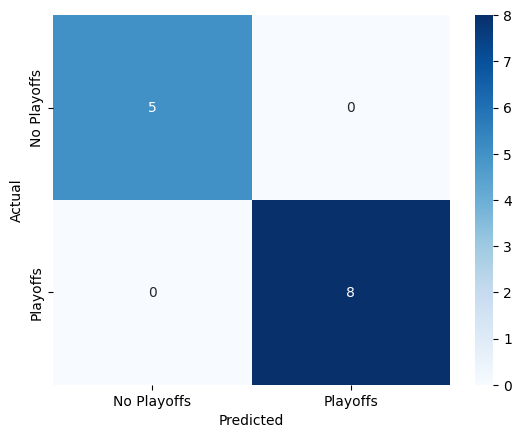

<module 'matplotlib.pyplot' from '/home/john/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

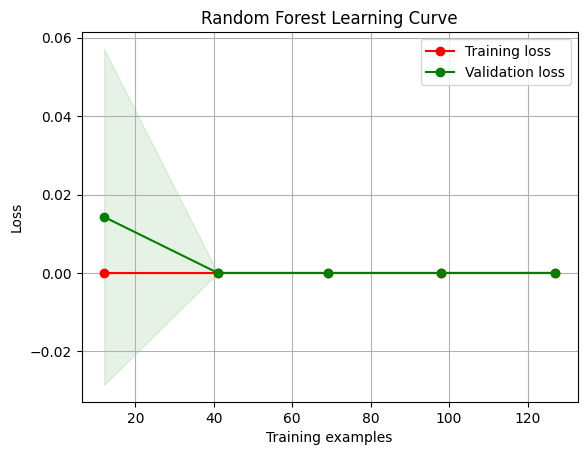

In [15]:
clf = RandomForestClassifier()

y_pred = print_results(clf, X_train, X_test, y_train, y_test)

plot_learning_curve(clf, 'Random Forest Learning Curve', X, y)

As we expected, the model performs very well, with a 100% accuracy. From the learning curve we can see that the model is a good model, as the training and validation losses are low and are very close to each other.

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[5 0]
 [0 8]]


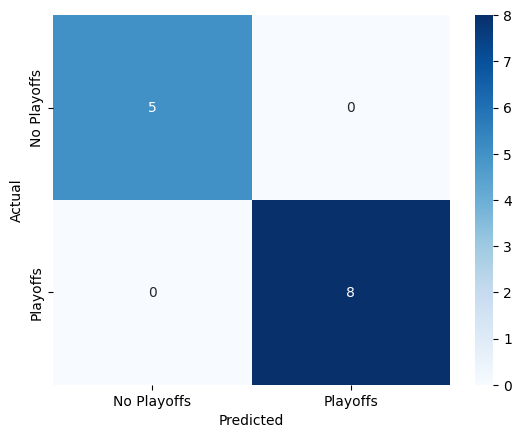

Cross-Validation Results:
Mean Accuracy: 100.00%
Standard Deviation: 0.00


In [16]:
force_qualify_8_teams(clf, X_test, y_test)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### KNN

Accuracy: 0.8461538461538461
[[5 0]
 [2 6]]


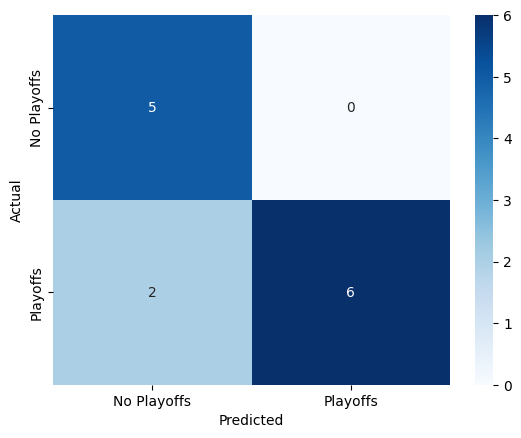

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.8461538461538461
[[4 1]
 [1 7]]


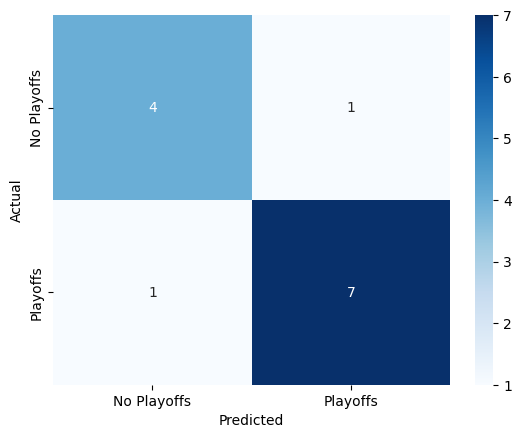

Cross-Validation Results:
Mean Accuracy: 83.71%
Standard Deviation: 0.11


<module 'matplotlib.pyplot' from '/home/john/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

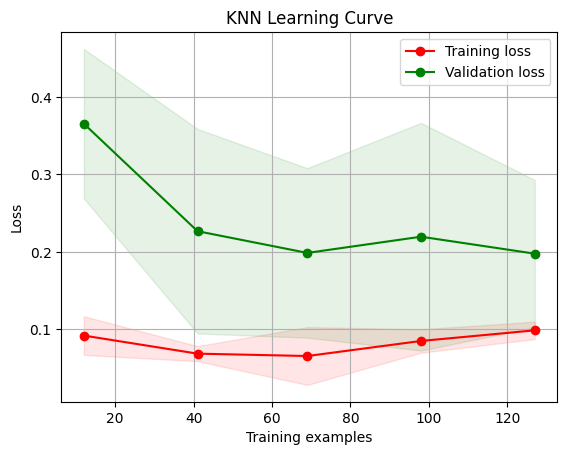

In [17]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

y_pred = print_results(knn_classifier, X_train_normalized, X_test_normalized, y_train, y_test)

y_pred = force_qualify_8_teams(knn_classifier, X_test_normalized, y_test)

scores = cross_validation(knn_classifier, X_normalized, y)
cross_val_scores.append(scores)

plot_learning_curve(knn_classifier, 'KNN Learning Curve', X_normalized, y)

KNN didn't perform as well as Random Forest, but it still performed very well, with a 91% accuracy. From the learning curve we can see that the model is underfitting, as the losses are quite significant and the training and validation losses are far from each other.

### Neural Network

Accuracy: 1.0
[[5 0]
 [0 8]]


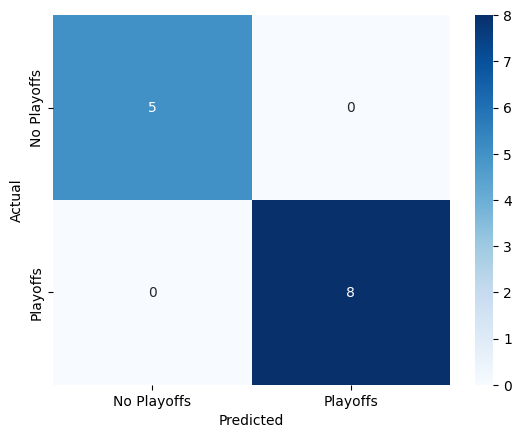

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[5 0]
 [0 8]]


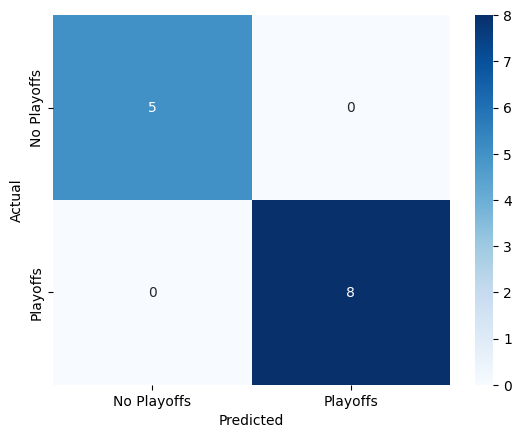

Cross-Validation Results:
Mean Accuracy: 92.24%
Standard Deviation: 0.06


<module 'matplotlib.pyplot' from '/home/john/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

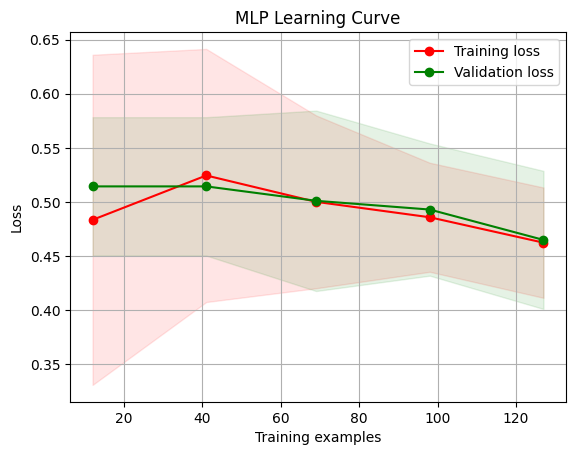

In [18]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
    
y_pred = print_results(mlp_classifier, X_train_normalized, X_test_normalized, y_train, y_test)

force_qualify_8_teams(mlp_classifier, X_test_normalized, y_test)

scores = cross_validation(mlp_classifier, X_normalized, y)
cross_val_scores.append(scores)

plot_learning_curve(mlp_classifier, 'MLP Learning Curve', X, y)

The neural network performed very well, with a 100% accuracy. From the learning curve we can see that the model is close to a good model, as the training and validation losses are merging each other, however they are quite high. This is indicating that adding more instances to our training set will not significantly increase the performance of the model.

### Conclusions

Using the current year information, the best model at their best. This permitted as to see which models will have a better performance with the data from the previous years, when we don't have the current year information.

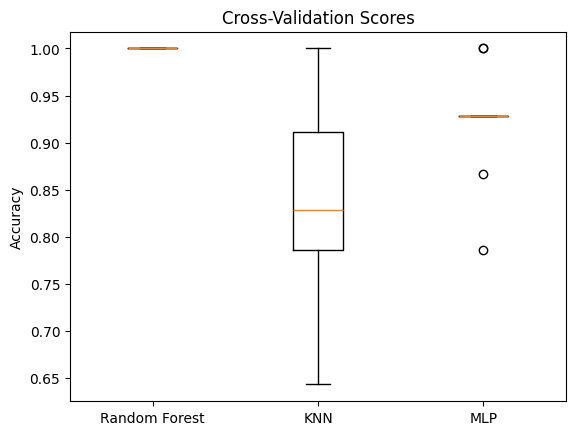

In [19]:
plt.boxplot(cross_val_scores, labels=['Random Forest', 'KNN', 'MLP'])
plt.title('Cross-Validation Scores')
plt.ylabel('Accuracy')
plt.show()

The Random Forest Classifier seems to be performing better than the other classifiers.

In the next chapter we will explore using a rolling window to use past years for the predictions

## Rolling window

### Rolling window functions

We will use a rolling window to predict the next season.
In this dataset, 3 years are combined, with more weight given to the most recent year, and combining that historic data with the target variable (playoff) from the target year (the n+1 year)

In [20]:
# Define the rolling window size (number of past years to consider)
ROLLING_WIN_SIZE = 3  # You can adjust this value
PREDICTION_YEAR = 11

historical_data_df = teams_df[teams_df['year'] < PREDICTION_YEAR]

def create_rolling_window_dataset(df, rolling_win_size):
    '''This function creates a list of dataframes, where each 
    dataframe contains the data from the previous n years.
    It creates an entry for each year that the team has played.'''

    df_rolling = []
    for year in range(rolling_win_size + 1, PREDICTION_YEAR + 1):
        df_year = df[df['year'] == year]
        df_prev_years = df[(df['year'] < year) & (df['year'] >= year - rolling_win_size)]

        # Take the data into a df for each team
        for team in df_year['tmID'].unique():
            # Take the data from the previous years for the same team
            df_team_prev_years = df_prev_years[df_prev_years['tmID'] == team]

            # Add the dataframe to the list
            df_rolling.append(df_team_prev_years)

    return df_rolling

def generate_weights(window_size):
    weights = np.linspace(0.1, 1, window_size)
    weights /= weights.sum()  # Normalize weights to ensure they sum to 1
    return weights

In [21]:
def rolling_window_df():
    # Create the rolling window datasets
    rolling_window_historic = create_rolling_window_dataset(teams_df,  ROLLING_WIN_SIZE)

    weighted_features = teams_df.drop(['year', 'tmID', 'confID', 'playoff'], axis=1).select_dtypes(include=np.number).columns.tolist()
    
    # Create a new dataframe to store the rolling window data
    rolling_data = pd.DataFrame(columns=teams_df.columns)

    for window in rolling_window_historic:

        #Create a new empty line for the rolling_data dataframe
        rolling_data_line = pd.DataFrame(columns=teams_df.columns)

        if len(window) != 0:
            #1. Get the weights for the weighted average
            weights = generate_weights(len(window))

            #2. Get the weighted average of the weighted features
            #Note: The weighted average is calculated as follows:
            #weighted average = sum of (weight * feature value) / sum of weights
            #For example, if the weights are [0.2, 0.3, 0.5] and the feature values are [10, 20, 30], then the weighted average is:
            #weighted average = (0.2 * 10 + 0.3 * 20 + 0.5 * 30) / (0.2 + 0.3 + 0.5) = 24
            for feature in weighted_features:
                weighted_average = np.average(window[feature].values, weights=weights)
                rolling_data_line[feature] = [weighted_average]

            #3. Join that data with the data from the following year (the year we want to predict)
            #Note: The data from the following year will be used as the target label, get next year from the teams_df dataframe
            next_year = window['year'].max() + 1
            next_year_data = teams_df[(teams_df['tmID'] == window['tmID'].values[0]) & (teams_df['year'] == next_year)]

        #Add year, confID, tmID, and playoff columns
        try:
            rolling_data_line['year'] = next_year
            rolling_data_line['tmID'] = window['tmID'].values[0]
            rolling_data_line['confID'] = next_year_data['confID'].values[0]
            rolling_data_line['playoff'] = next_year_data['playoff'].values[0]
        except:
            #If there is no data for the next year, skip this line
            #print('No data for next year')
            continue
        
        #4. Concat the data to the rolling_data dataframe
        rolling_data = pd.concat([rolling_data, rolling_data_line])

    rolling_data = rolling_data.reset_index(drop=True)

    return rolling_data

In [22]:
rolling_data = rolling_window_df()
rolling_data.head()

,year,confID,rank,playoff,firstRound,semis,finals,o_fgm,o_fga,o_ftm,o_fta,o_3pa,o_oreb,o_dreb,o_reb,o_asts,o_pf,o_stl,o_to,o_blk,d_fgm,d_fga,d_fta,d_3pm,d_3pa,d_oreb,d_reb,d_asts,d_pf,d_stl,d_to,d_blk,GP_x,attend,win_percentage,loss_percentage,home_win_percentage,home_loss_percentage,away_win_percentage,away_loss_percentage,conference_win_percentage,conference_loss_percentage,tmID_encoded,GP_y,GS,minutes,oRebounds,PF,fgAttempted,ftMade,threeAttempted,dq,PostGS,PostSteals,PostBlocks,PostftAttempted,PostthreeAttempted,PostDQ,total_rebounds,total_blocks,total_steals,total_turnovers,FG%,FT%,award,Avg_Rebounds_Per_Game,Avg_Steals_Per_Game,Avg_Turnovers_Per_Game,Usability,POSITION_METRIC,height,weight,birthYear,num_seasons,tmID
0,4,0,3.030303,1,0.636364,0.333333,0.166667,764.545455,1793.515152,459.757576,612.787879,485.454545,304.515152,646.939394,951.454545,489.666667,637.000000,231.848485,435.333333,107.090909,768.787879,1827.454545,593.151515,126.969697,374.090909,313.212121,918.212121,480.151515,592.757576,227.424242,431.787879,111.212121,32.0,105336.393939,0.543561,0.456439,0.664773,0.335227,0.422348,0.577652,0.598846,0.401154,1.0,23.467135,14.257953,538.241334,27.609712,52.625420,155.567185,43.201263,32.616883,0.629110,1.629992,2.225059,1.194213,4.363881,3.586390,0.0,96.525942,11.864014,21.939759,38.153725,0.365055,0.691942,0.000000,3.149536,0.743026,1.173942,0.481452,0.312820,72.486975,174.109120,1973.448362,5.239996,CHA
1,4,0,4.696970,1,0.227273,0.030303,0.000000,763.969697,1803.818182,410.424242,538.030303,363.000000,297.848485,665.696970,963.545455,491.242424,560.181818,238.636364,453.939394,83.484848,751.272727,1799.909091,499.090909,141.515152,428.575758,284.272727,906.272727,498.606061,612.515152,240.151515,458.181818,114.151515,32.0,147813.545455,0.450758,0.549242,0.492424,0.507576,0.409091,0.590909,0.477633,0.522367,3.0,21.890752,12.868913,489.232659,21.389290,40.564592,138.885564,30.127659,24.691424,0.319663,0.462749,0.711484,0.257110,1.105937,1.245224,0.0,73.188705,5.813782,18.794027,33.307709,0.383771,0.605077,0.003494,2.553044,0.640803,1.132330,0.434027,0.299631,70.576831,164.161141,1975.845068,5.140575,CLE
2,4,0,4.878788,1,0.030303,0.000000,0.000000,796.181818,1913.818182,466.181818,620.272727,482.424242,331.939394,602.000000,933.939394,449.636364,655.121212,300.909091,483.151515,118.030303,807.515152,1857.848485,636.515152,156.151515,429.030303,345.818182,1020.575758,525.030303,624.666667,267.454545,540.181818,110.000000,32.0,115756.787879,0.468750,0.531250,0.628788,0.371212,0.308712,0.691288,0.555556,0.444444,4.0,23.909225,12.593214,501.197295,25.473999,48.698040,150.428337,34.512186,38.215120,0.229302,0.052531,0.072856,0.068442,0.087218,0.123231,0.0,71.243106,8.935145,24.656429,38.093676,0.377134,0.697222,0.000000,2.466986,0.863080,1.319970,0.436435,0.344340,72.204350,174.075338,1974.858903,5.499480,CON
3,4,0,7.484848,1,0.000000,0.000000,0.000000,774.848485,1921.030303,454.848485,617.575758,372.151515,346.848485,681.787879,1028.636364,476.515152,612.242424,212.575758,526.000000,112.666667,839.333333,1933.969697,600.515152,139.060606,406.787879,303.363636,981.606061,458.909091,623.787879,272.424242,462.393939,129.545455,32.0,100025.030303,0.301136,0.698864,0.420455,0.579545,0.181818,0.818182,0.313131,0.686869,5.0,24.092255,9.217438,415.851460,23.305392,39.916021,122.201636,24.921106,23.696448,0.097473,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,66.027910,7.937638,13.273662,31.719965,0.375762,0.648627,0.000000,2.418827,0.496050,1.212374,0.391273,0.330455,71.510897,163.920940,1976.307331,4.874595,DET
4,4,1,2.666667,1,0.530303,0.060606,0.060606,760.575758,1828.363636,444.454545,572.636364,375.969697,313.757576,706.000000,1019.757576,444.666667,486.272727,258.454545,447.757576,114.333333,721.575758,1884.515152,472.727273,149.696970,473.696970,303.848485,971.696970,449.636364,593.545455,255.575758,454.636364,88.181818,32.0,186587.242424,0.703598,0.296402,0.812500,0.187500,0.594697,0.405303,0.717172,0.282828,6.0

### Random Forest with Rolling window

In [23]:
y_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR]['playoff'].astype(int)
y_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['playoff'].astype(int)
X_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
X_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
X_train_normalized, X_test_normalized = normalize_df(X_train, X_test)
X_train_mnb, X_test_mnb = normalize_df_for_mnb(X_train, X_test) # Multinomial Naive Bayes Classifier only accepts non-negative values, let's use MinMaxScaler

X = pd.concat([X_train, X_test])
X_normalized = pd.concat([X_train_normalized, X_test_normalized])
X_mnb = np.concatenate((X_train_mnb, X_test_mnb))
y = pd.concat([y_train, y_test])

Accuracy: 0.6666666666666666
[[3 1]
 [3 5]]


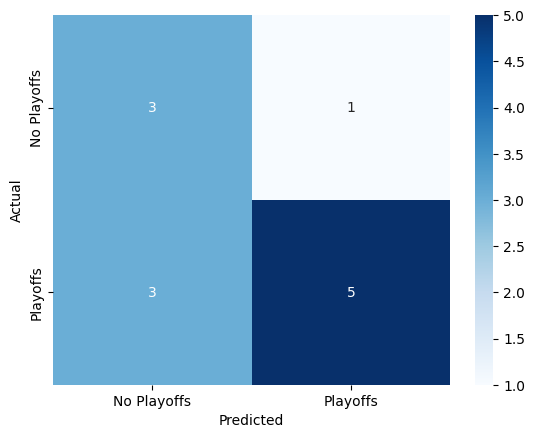

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6666666666666666
[[2 2]
 [2 6]]


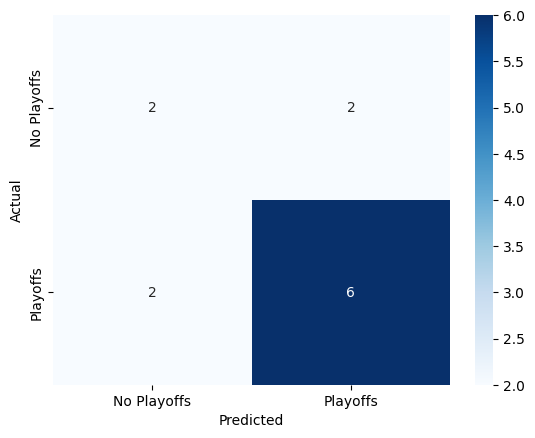

Cross-Validation Results:
Mean Accuracy: 63.27%
Standard Deviation: 0.12


<module 'matplotlib.pyplot' from '/home/john/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

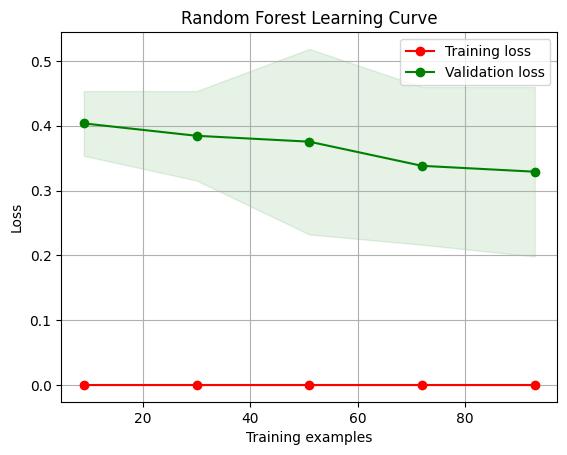

In [24]:
clf = RandomForestClassifier(n_estimators=100)

y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(clf, X_test, y_test)

scores = cross_validation(clf, X, y)

plot_learning_curve(clf, 'Random Forest Learning Curve', X, y)

The learning curve tells us that the model with 100 estimators does not look like a good model, as the training and validation losses are far from each other and the losses are quite significant.

## Grid Search

Now we will perform some grid search on some models with the rolling window data, to see if we can improve the results.

### Random Forest

Now, we will try to find what are the best parameters for the Random Forest, KNN and M Naive Bayes models, using Grid Search, and tune this models to see if we can improve the results.

In [25]:
# Use grid search to find the best parameters
cross_val_scores = []
best_clf = {}
grid_search_params = {}
grid_search_models = {}

parameters = {
    'n_estimators': [5, 10],
    'max_depth': [3, 5], 
    'max_features': ['sqrt', 'log2'], 
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10] 
}

clf = RandomForestClassifier()
grid_search_models['Random Forest'] = clf
grid_search_params['Random Forest'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['Random Forest'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
{'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 5}
0.73
RandomForestClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=5)


Accuracy: 0.6666666666666666
[[2 2]
 [2 6]]


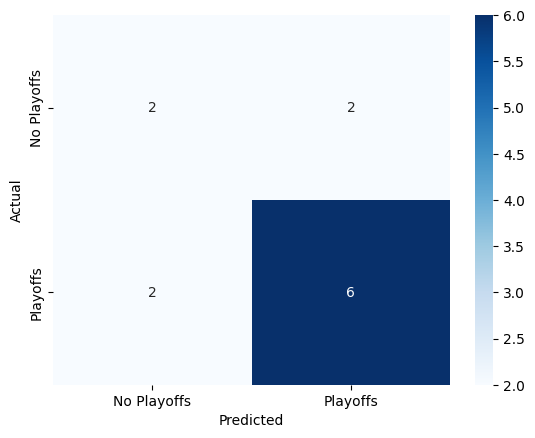

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6666666666666666
[[2 2]
 [2 6]]


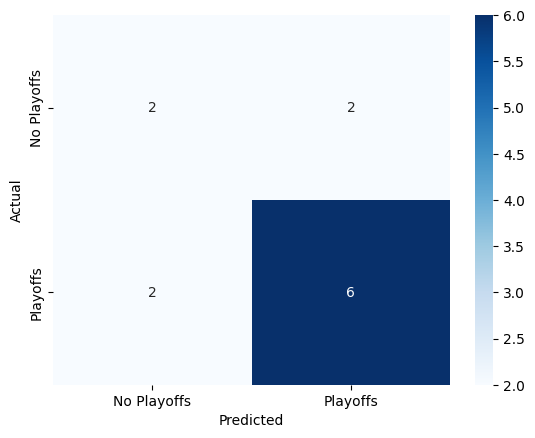

Cross-Validation Results:
Mean Accuracy: 61.36%
Standard Deviation: 0.16


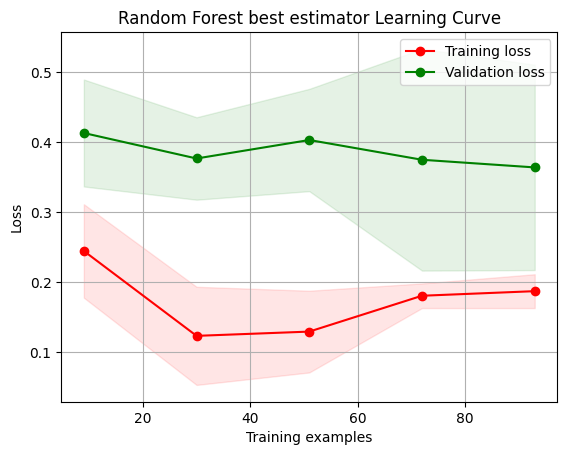

In [26]:
# Use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(clf, X_test, y_test)
scores = cross_validation(clf, X, y)
plot_learning_curve(clf, 'Random Forest best estimator Learning Curve', X, y)
cross_val_scores.append(scores)

The curve is showing that the model improved a little bit, as the validation losses are closer now to the training losses, but the losses are still quite significant.

### KNN

In [27]:
# Use grid search to find the best parameters
parameters = {'n_neighbors': [3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance']}
clf = KNeighborsClassifier()
grid_search_models['KNN'] = clf
grid_search_params['KNN'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_normalized, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['KNN'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'n_neighbors': 7, 'weights': 'uniform'}
0.6544444444444444
KNeighborsClassifier(n_neighbors=7)


Accuracy: 0.6666666666666666
[[2 2]
 [2 6]]


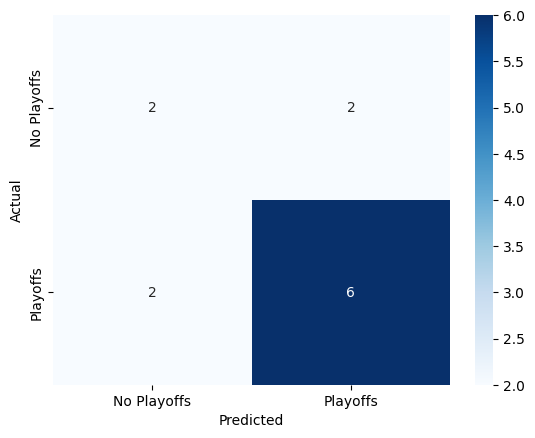

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6666666666666666
[[2 2]
 [2 6]]


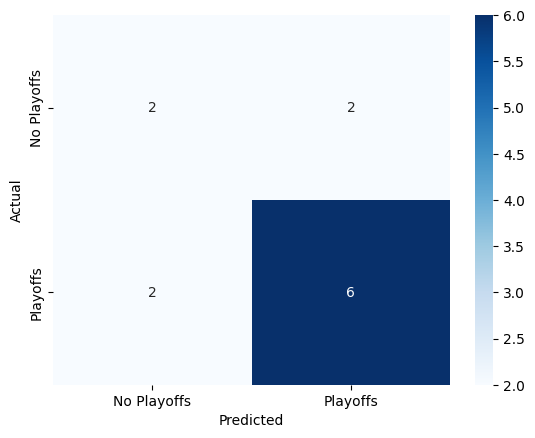

Cross-Validation Results:
Mean Accuracy: 69.00%
Standard Deviation: 0.13


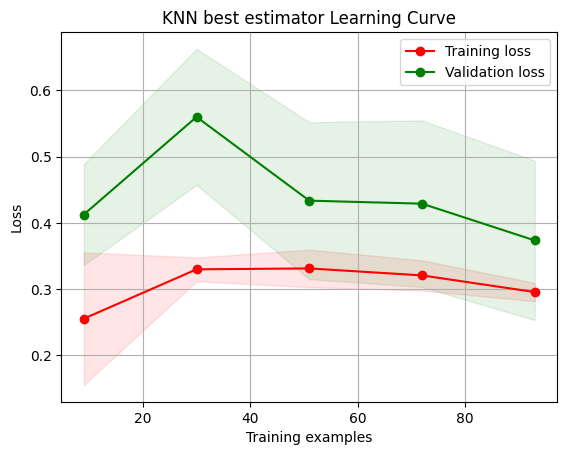

In [28]:
# Use the best parameters to train the model
y_pred = print_results(clf, X_train_normalized, X_test_normalized, y_train, y_test)
force_qualify_8_teams(clf, X_test_normalized, y_test)
scores = cross_validation(clf, X_normalized, y)
plot_learning_curve(clf, 'KNN best estimator Learning Curve', X, y)
cross_val_scores.append(scores)

### Multinomial NaiveBayes

In [29]:
# Use grid search to find the best parameters
parameters = {'alpha': [0.1, 0.5, 1, 2, 5, 10]}
clf = MultinomialNB()
grid_search_models['Multinomial NB'] = clf
grid_search_params['Multinomial NB'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_mnb, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['Multinomial NB'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'alpha': 0.1}
0.6455555555555555
MultinomialNB(alpha=0.1)


Accuracy: 0.6666666666666666
[[3 1]
 [3 5]]


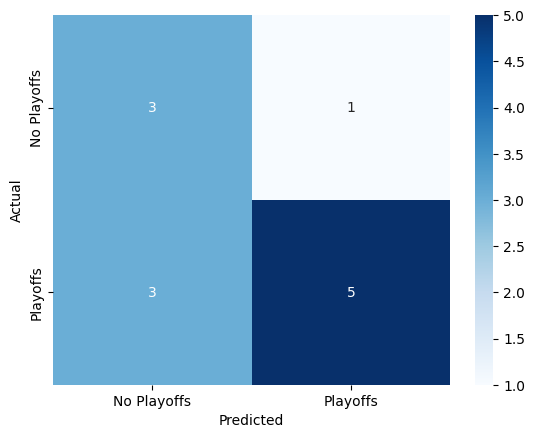

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6666666666666666
[[2 2]
 [2 6]]


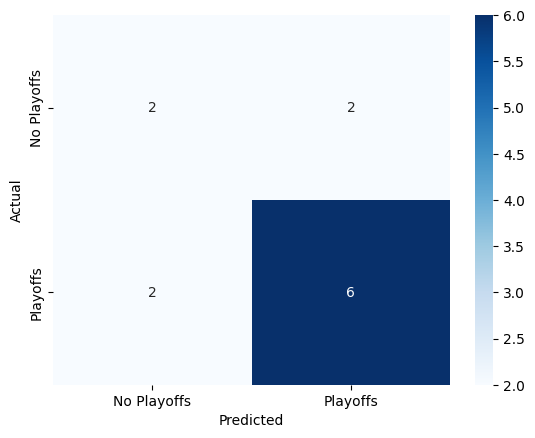

Cross-Validation Results:
Mean Accuracy: 66.22%
Standard Deviation: 0.13


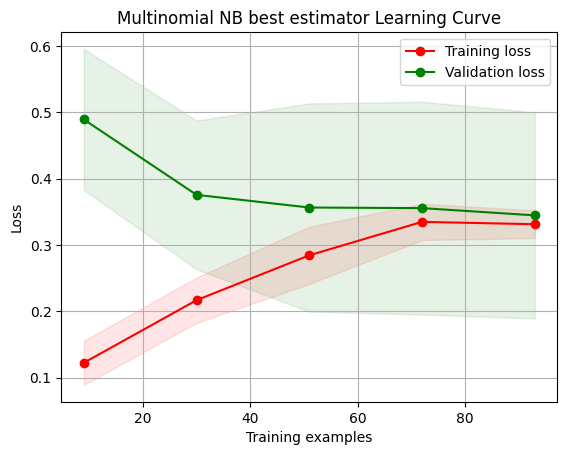

In [31]:
# Use the best parameters to train the model
y_pred = print_results(clf, X_train_mnb, X_test_mnb, y_train, y_test)
force_qualify_8_teams(clf, X_test_mnb, y_test)
scores = cross_validation(clf, X_train_mnb, y_train)
plot_learning_curve(clf, 'Multinomial NB best estimator Learning Curve', X_mnb, y)
cross_val_scores.append(scores)

### Gradient Boosting

In [32]:
parameters = {
    "learning_rate": [0.01, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 2),
    "min_samples_leaf": np.linspace(0.1, 0.5, 2),
    "max_depth":[3,8],
    "max_features":["log2",None],
    "subsample":[0.8, 1.0],
    "n_estimators":[100]
}
clf = GradientBoostingClassifier()
grid_search_models['Gradient Boosting'] = clf
grid_search_params['Gradient Boosting'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['Gradient Boosting'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'n_estimators': 100, 'subsample': 0.8}
0.6755555555555556
GradientBoostingClassifier(max_features='log2', min_samples_leaf=0.1,
                           min_samples_split=0.5, subsample=0.8)


Accuracy: 0.5833333333333334
[[3 1]
 [4 4]]


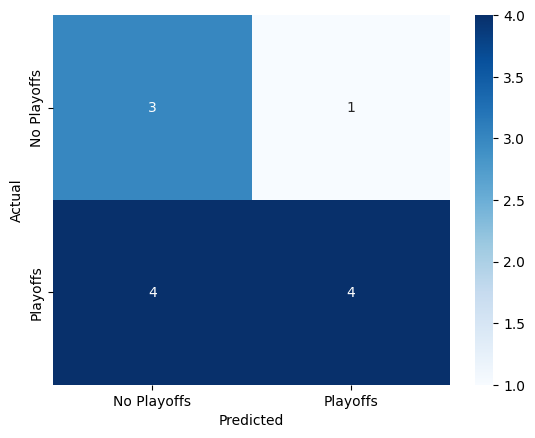

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6666666666666666
[[2 2]
 [2 6]]


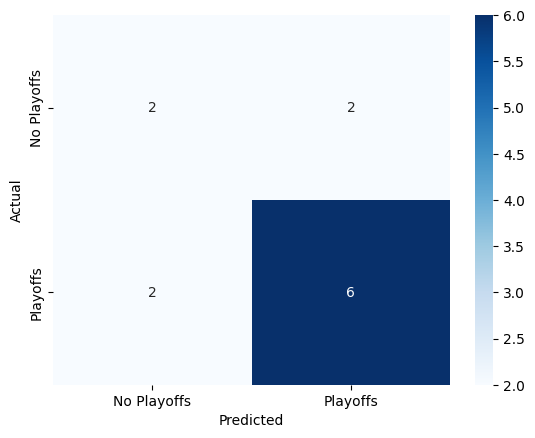

Cross-Validation Results:
Mean Accuracy: 60.09%
Standard Deviation: 0.15


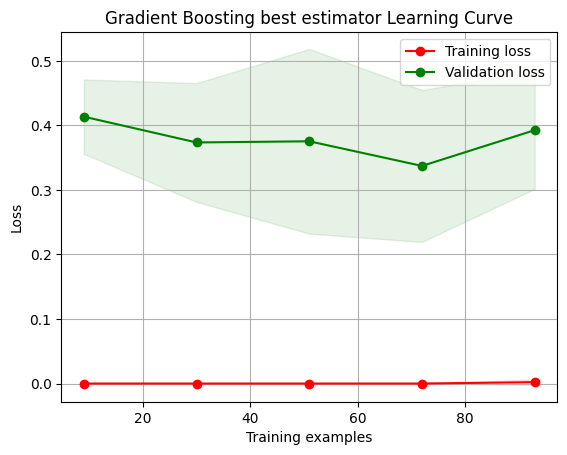

In [33]:
# Use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(clf, X_test, y_test)
scores = cross_validation(clf, X, y)
plot_learning_curve(clf, 'Gradient Boosting best estimator Learning Curve', X, y)
cross_val_scores.append(scores)

### XBoost

In [34]:
X_train['confID'] = X_train['confID'].astype('bool')
X_test['confID'] = X_test['confID'].astype('bool')
X = pd.concat([X_train, X_test])

parameters = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.8, 1.0],
    'n_estimators': [100, 200]
}
clf = xgb.XGBClassifier()
grid_search_models['XGBoost'] = clf
grid_search_params['XGBoost'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['XGBoost'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
0.6644444444444444
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Accuracy: 0.6666666666666666
[[3 1]
 [3 5]]


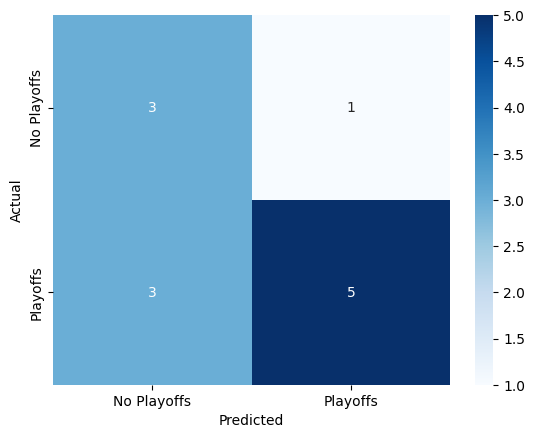

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6666666666666666
[[2 2]
 [2 6]]


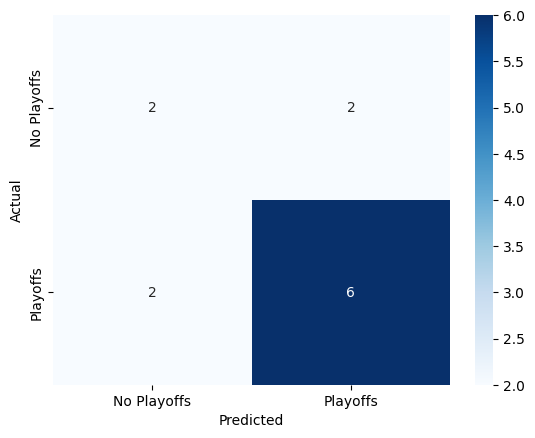

Cross-Validation Results:
Mean Accuracy: 64.91%
Standard Deviation: 0.17


<module 'matplotlib.pyplot' from '/home/john/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

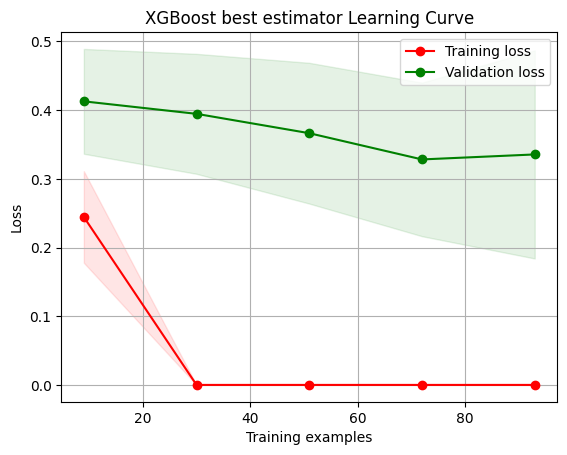

In [35]:
# Use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(clf, X_test, y_test)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)
plot_learning_curve(clf, 'XGBoost best estimator Learning Curve', X, y)

### MLP

In [36]:
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [1000],
    'learning_rate_init': [0.01]
}
clf = MLPClassifier()
grid_search_models['MLP'] = clf
grid_search_params['MLP'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_normalized, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['MLP'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'sgd'}
0.6866666666666668
MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50),
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000,
              solver='sgd')


Accuracy: 0.5833333333333334
[[3 1]
 [4 4]]


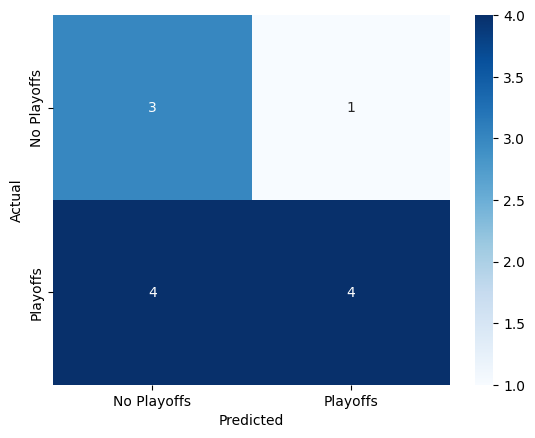

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6666666666666666
[[2 2]
 [2 6]]


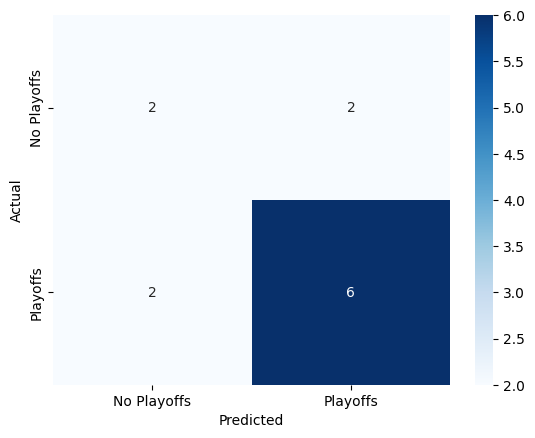

Cross-Validation Results:
Mean Accuracy: 59.36%
Standard Deviation: 0.12


/home/john/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklea

<module 'matplotlib.pyplot' from '/home/john/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

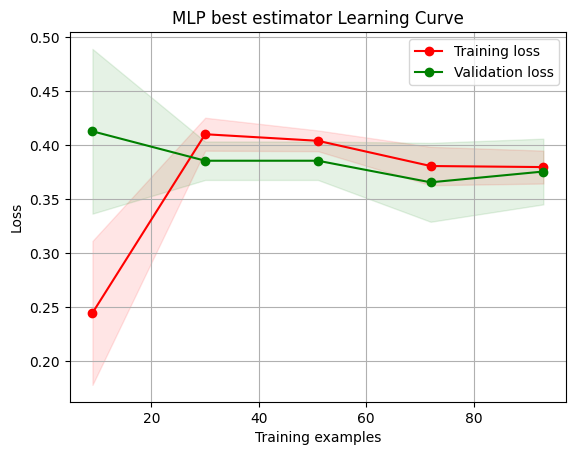

In [37]:
# Use the best parameters to train the model
y_pred = print_results(clf, X_train_normalized, X_test_normalized, y_train, y_test)
force_qualify_8_teams(clf, X_test_normalized, y_test)
scores = cross_validation(clf, X_normalized, y)
cross_val_scores.append(scores)
plot_learning_curve(clf, 'MLP best estimator Learning Curve', X, y)

SVM

In [38]:
parameters = {
    'C': [0.01, 0.1, 1], 
    'gamma': ['scale'], 
    'kernel': ['linear'],
    'class_weight': ['balanced'],
    'probability': [True]
}
clf = svm.SVC()
grid_search_models['SVM'] = clf
grid_search_params['SVM'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_normalized, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
best_clf['SVM'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear', 'probability': True}
0.601111111111111
SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True)


Accuracy: 0.5
[[2 2]
 [4 4]]


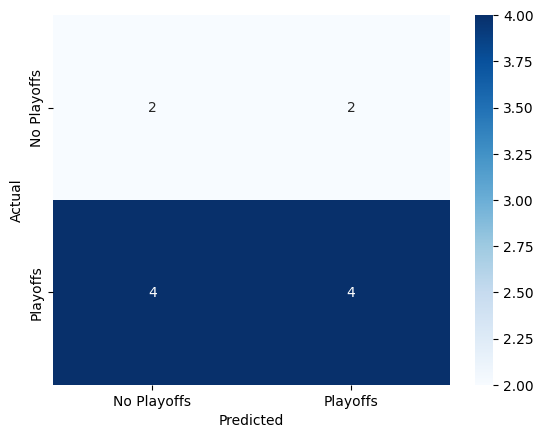

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6666666666666666
[[2 2]
 [2 6]]


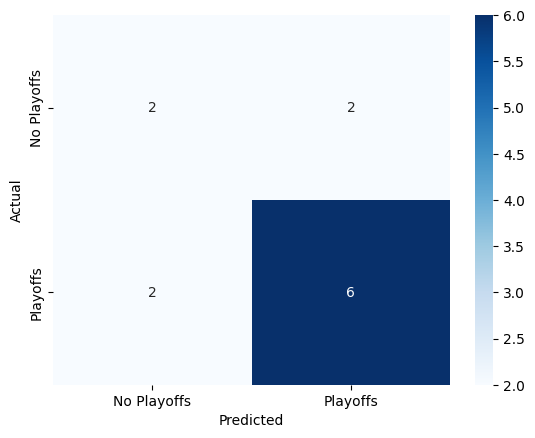

Cross-Validation Results:
Mean Accuracy: 55.55%
Standard Deviation: 0.10


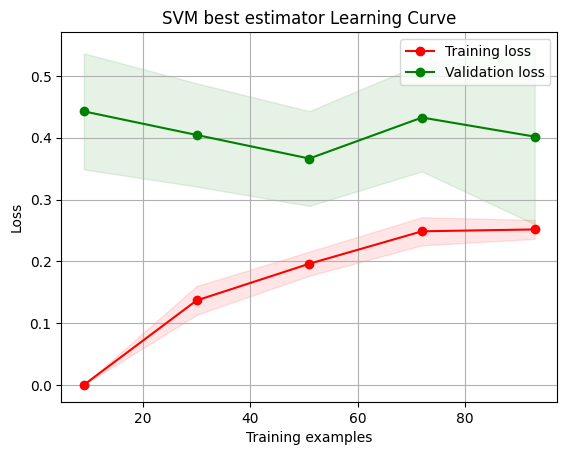

In [39]:
# Use the best parameters to train the model
y_pred = print_results(clf, X_train_normalized, X_test_normalized, y_train, y_test)
force_qualify_8_teams(clf, X_test_normalized, y_test)
scores = cross_validation(clf, X_normalized, y)
plot_learning_curve(clf, 'SVM best estimator Learning Curve', X_normalized, y)
cross_val_scores.append(scores)

### Plotting the results

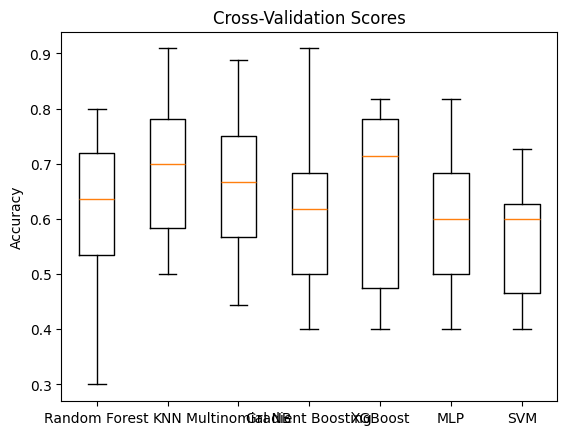

In [40]:
#plot the cross validation scores
plt.boxplot(cross_val_scores, labels=best_clf.keys())
plt.title('Cross-Validation Scores')
plt.ylabel('Accuracy') 
plt.show()

After getting our best classifier, we will try different numbers of ROLLING WINDOW to see if we can improve the results.

The best classifier is Random Forest with a score of 0.73


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc2dc4e4160>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc2dc4e6a70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc2dc4e7be0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc2dc4e53f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc2dc4e4370>,
 'means': []}

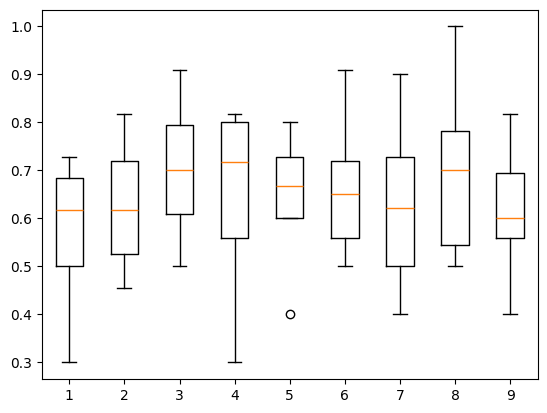

In [41]:
# Initialize variables to store the best score and estimator
best_score = -1
best_estimator = None
best_clf_name = None

# Iterate over the best_clf dictionary
for clf_name, (score, estimator) in best_clf.items():
    # If this classifier's score is higher than the current best score, update the best score and estimator
    if score > best_score:
        best_score = score
        best_estimator = estimator
        best_clf_name = clf_name

print(f"The best classifier is {best_clf_name} with a score of {best_score}")

cross_val_scores = []
best_year = 0
best_score = -1
for i in range(1, 10):
    ROLLING_WIN_SIZE = i
    rolling_data = rolling_window_df()

    clf = best_estimator

    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])

    y_pred = print_results(clf, X_train, X_test, y_train, y_test, output=False)

    scores = cross_validation(clf, X, y, False)
    cross_val_scores.append(scores)

    if scores.mean() > best_score:
        best_score = scores.mean()
        best_year = i

plt.boxplot(cross_val_scores, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [42]:
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [1000],
    'learning_rate_init': [0.01]
}
clf = MLPClassifier()
grid_search_models['MLP'] = clf
grid_search_params['MLP'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_normalized, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

clf = grid_search.best_estimator_
best_clf['MLP'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'sgd'}
0.6644444444444444
MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000,
              solver='sgd')


Now we will use the rolling window we created on the previous notebook, we will base our statistics on the last years of the players that currrently play on the roster of the team.
As we could ee from before, when creating the rolling window data the more years we use in the past, less their weight. So we can barely notice any difference between using 3 or 10 years of data into account. So we will use 3 years of data, as it is the most recent data for this next part

In [43]:
labels = []
cross_val_scores = []

rolling_data = pd.read_csv('../prep_data/rolling_window/data_with_' + str(3) +'_years_in_the_past.csv')

y_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR]['playoff'].astype(int)
y_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['playoff'].astype(int)
confIDs = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['confID']
tmIDs = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['tmID']
X_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
X_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

for model in grid_search_models.keys():
    if model in ['KNN', 'SVM', 'XGBoost', 'MLP']:
        # Normalize the data as KNN, Neural Networks, SVM, ... expect the data to be normalized
        X_train_model, X_test_model = normalize_df(X_train, X_test)
        X_model = pd.concat([X_train_model, X_test_model])
    else:
        X_train_model, X_test_model = X_train, X_test
        X_model = X
        
    clf = grid_search_models[model]
    parameters = grid_search_params[model]

    labels.append(model + '_w' + str(3) + 'years')
    
    clf = best_clf[model][1]
    clf.fit(X_train_model, y_train)
    

    best_clf[model] = (best_clf[model][0], best_clf[model][1], [X_train_model, X_test_model, y_train, y_test], 3)

    y_pred = print_results(clf, X_train_model, X_test_model, y_train, y_test, output=False)

    scores = cross_validation(clf, X_model, y, False)
    cross_val_scores.append(scores)

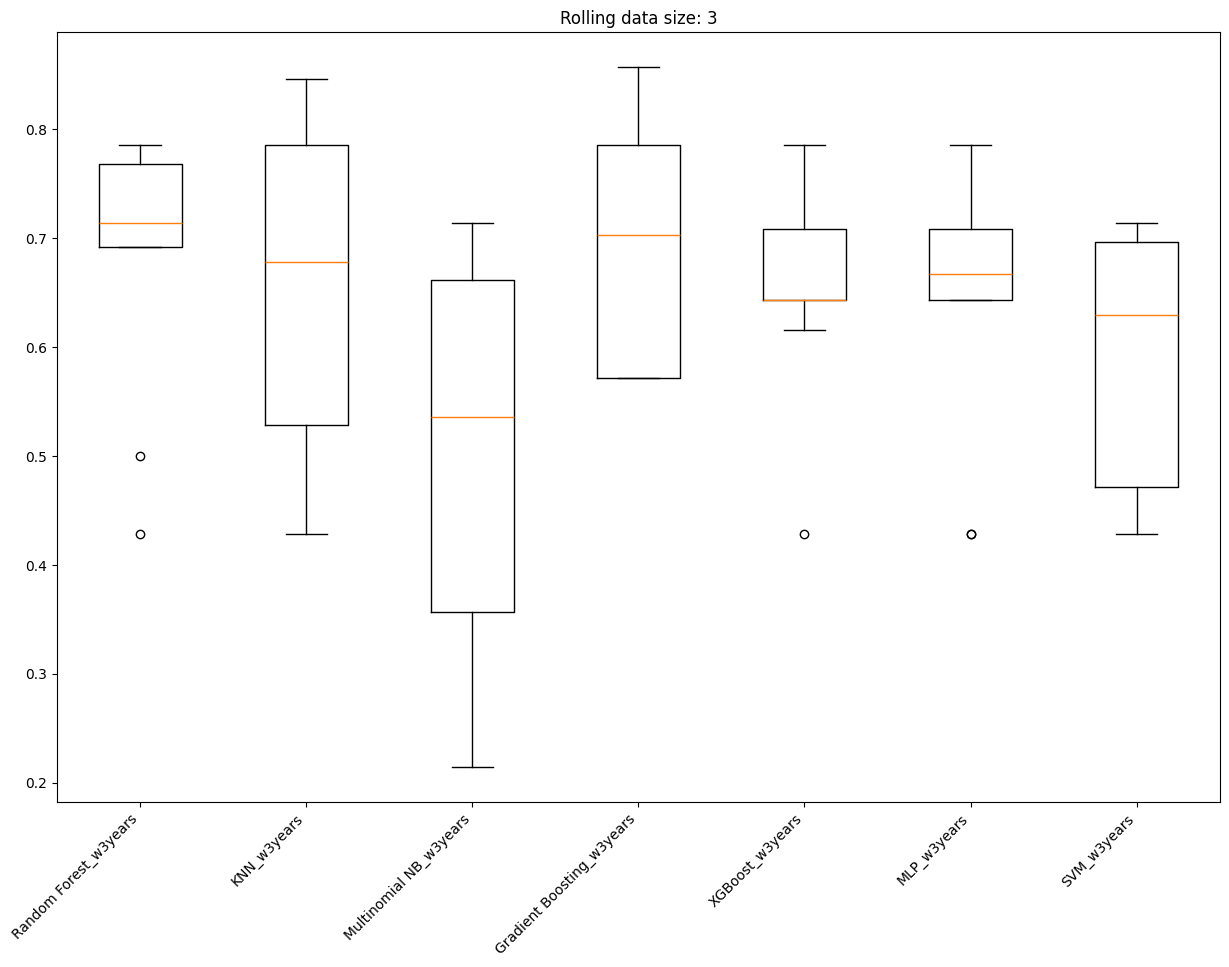

Random Forest( score: 0.73, with 3 years behind, estimator:RandomForestClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=5))
KNN( score: 0.6544444444444444, with 3 years behind, estimator:KNeighborsClassifier(n_neighbors=7))
Multinomial NB( score: 0.6455555555555555, with 3 years behind, estimator:MultinomialNB(alpha=0.1))
Gradient Boosting( score: 0.6755555555555556, with 3 years behind, estimator:GradientBoostingClassifier(max_features='log2', min_samples_leaf=0.1,
                           min_samples_split=0.5, subsample=0.8))
XGBoost( score: 0.6644444444444444, with 3 years behind, estimator:XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,

In [44]:
fig = plt.figure(figsize=(15, 10))
plt.boxplot(cross_val_scores, labels=labels)
plt.xticks(rotation=45, ha="right")
plt.title('Rolling data size: ' +  str(3))
plt.show()

best_score = -1
best_classifier = None
for best_name, best in best_clf.items():
    print(best_name + '( score: ' + str(best[0]) + ', with ' + str(3) + ' years behind, estimator:' + str(best[1]) + ')')

    if best[0] > best_score:
        best_score = best[0]
        best_classifier = best

Accuracy: 0.75
[[3 1]
 [2 6]]


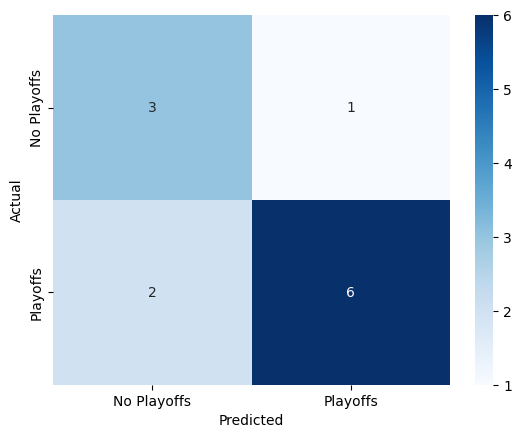

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.8333333333333334
[[3 1]
 [1 7]]


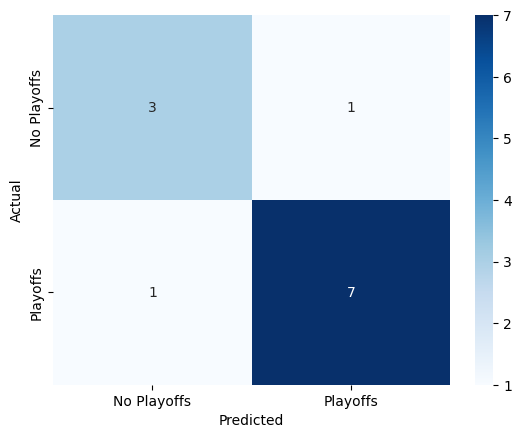

,tmID,year,confID,playoff,playoff_predict,playoff_predict_without_8
0,ATL,11,0,1,0,0
1,CHI,11,0,0,0,0
2,CON,11,0,0,1,1
4,IND,11,0,1,1,1
7,NYL,11,0,1,1,1
11,WAS,11,0,1,1,0
3,DET,11,1,0,0,0
5,LAS,11,1,1,1,1
6,MIN,11,1,0,0,0
8,PHO,11,1,1,1,1


In [53]:
competition_data = pd.read_csv('../prep_data/rolling_window/data_with_' + str(3) +'_years_in_the_past.csv')

with open('results.txt', 'w') as f:
    y_pred_without_8 = print_results(best_classifier[1], best_classifier[2][0], best_classifier[2][1], best_classifier[2][2], best_classifier[2][3], False)
    y_pred = force_qualify_8_teams(best_classifier[1], best_classifier[2][1], y_test)

    X = pd.concat([best_classifier[2][0], best_classifier[2][1]])
    y = pd.concat([best_classifier[2][2], best_classifier[2][3]])
    # Convert y_pred_numeric to a DataFrame and reset the index
    y_pred_df = pd.DataFrame(y_pred, columns=["playoff_predict"])
    y_pred_without_8_df = pd.DataFrame(y_pred_without_8, columns=["playoff_predict_without_8"])

    # Filter competition_data for the prediction year
    competition_data = competition_data[rolling_data['year'] == PREDICTION_YEAR][['tmID', 'year', 'confID', 'playoff']].sort_values('tmID', ascending=True)

    # Merge competition_data with y_pred_df
    result = competition_data.reset_index(drop=True).join(y_pred_df)
    result = result.reset_index(drop=True).join(y_pred_without_8_df).sort_values(['confID', 'tmID'], ascending=True)

    display(result)

    # Write the result to a file
    f.write(str(result))